In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '.'

In [3]:
from collections import Counter


def get_sites(path_to_csv_files):
    """Returns :
    - dictionary of sites enumerated according frequency of use.
    """
    # Vars:

    # dictionary of site id's
    sites = Counter()
    # list of user files
    fns = glob(path_to_csv_files+"/*")

    # for every file
    for f in fns:
        # read user data
        ud = pd.read_csv(os.path.join(PATH_TO_DATA, f))
        # determine sites were visited
        sites.update(Counter(ud['site']))
        
    # return dictionary with sorted and enumerated sites
    result = {}
    for i, x in enumerate(sites.most_common()):
        result[x[0]] = (i+1, x[1])
    return result, fns

In [4]:
def term_matrix(docs):
    """
    Returns parameters for construction sparse matrix from initial `docs` table.
    vocabulary - dictionary of terms, value as index.
    indicies - list of term indicies.
    data - list of data existence
    indptr - 
    """
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
                index = vocabulary.setdefault(term, term)
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))
    return data, indices, indptr

In [5]:
def prepare_sparse_train_set_window(path_to_csv_files, session_length=10, window_size=10):
    """Returns:
    - train_data as sparse matrix;
    - column of `user id` as answers
    """

#     ----- Get sites (dictionary)
    sites, fns = get_sites(path_to_csv_files)


#     ----- Determine shape parameters of 'sparse matrix'

#     Vars:
#     sites usage data from .csv : (name , user_data, sessions_number)
    ud = []
#     for determination session number according input parameters: `session_length` and `window_size`
    session_counter = 0

#     For every .csv file
    for f in fns:
        #         Read user data (as DataFrame)
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, f))
        
        #         Add 'sid' as 'site id' (info from sites)
        user_data['site'] = user_data['site'].apply(lambda x: sites[x][0])
        #         Determine number of sessions in the doc:
        sessions_number = int(np.ceil(len(user_data)/window_size))
        session_counter+= sessions_number
        #
        name = int(f[-8:-4])
#         Save user data
        ud.append((name , user_data, sessions_number))
    
#     ----- Construct training table (ndarray of zeros) with shape = (session_counter, session_length+1)
    train_data = np.zeros(shape=(session_counter, session_length+1))


#     ----- Fill training table

#     Vars:
#     Row counter
    active_row = 0

#     For every user data
    for user_data in ud:
        "Read user data"
        name , doc, sessions_number = user_data

#         Write session data (sites) to Training table:
        for i in range(sessions_number):
            start_row = i *window_size
            end_row = start_row+session_length
            for col, s in enumerate(doc['site'][start_row:end_row]):
                train_data[active_row + i, col] = s
                
#         Write user data to train table
        for i in range(active_row, active_row+sessions_number):
            train_data[i, session_length] = name

#         Update row counter
        active_row += sessions_number
    
    
#     ---- Divide training table on features and answers 
    X, y  = train_data[:, :-1], train_data[:, -1]
    
#     ---- Transform training table to sparse matrix with term features
    X_sparse = csr_matrix(term_matrix(X))[:,1:]

    return X_sparse, y.astype('int')

In [6]:
%%time
path = "3users"
train_data_toy, site_freq_3users = prepare_sparse_train_set_window(path)
train_data_toy.todense()

CPU times: user 16.6 ms, sys: 4.06 ms, total: 20.6 ms
Wall time: 23.2 ms


matrix([[1, 3, 1, 0, 1, 0, 1, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 2, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0]])

In [7]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                       session_length=5, window_size=3)

In [8]:
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [9]:
y_s5_w3

array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2])

In [10]:
import itertools

In [ ]:
%%time

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            print(f"{num_users} : {window_size} : {session_length}")
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, f'{num_users}users'),
                                                          session_length, window_size)
            data_lengths.append(len(y))
            with open(os.path.join(PATH_TO_DATA, 
                                   f'X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl'), 
                      'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 
                                   f'y_{num_users}users_s{session_length}_w{window_size}.pkl'), 
                      'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)

In [12]:
data_lengths

[14061, 20087, 20087, 20087, 28118, 28118, 28118, 28118]

In [13]:
sum(data_lengths)

186794

In [14]:
def write_answer(i, answer):
    with open(f"task2_{i}_answer", mode = "w") as file:
        file.write(str(answer))

In [15]:
answer = " ".join(map(str,data_lengths))
answer

'14061 20087 20087 20087 28118 28118 28118 28118'

In [16]:
write_answer(1,answer)

In [17]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [18]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,uid
session_id,,,,,,,,,,,
0,60,60,265,39,39,69,160,69,67,67,100
1,72,15,207,574,534,23,37,23,80,85,100
2,52,37,23,37,23,23,39,39,69,69,100
3,160,69,69,160,39,69,160,39,39,81,100
4,164,310,164,167,182,161,161,167,61,81,100


In [19]:
train_df[train_df.columns[10]].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: uid, dtype: int64

In [20]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [21]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

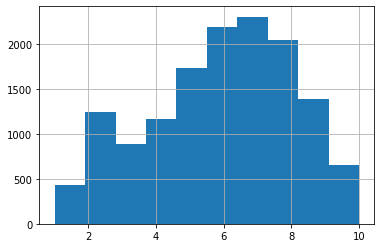

In [22]:
pd.Series(num_unique_sites).hist();

Вопрос 2. Распределено ли нормально число уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов (согласно критерию Шапиро-Уилка)?

Populating the interactive namespace from numpy and matplotlib


((array([-3.89403843, -3.6734386 , -3.55253248, ...,  3.55253248,
          3.6734386 ,  3.89403843]),
  array([ 1,  1,  1, ..., 10, 10, 10])),
 (2.3087399107781494, 5.951923760756702, 0.9770787039552072))

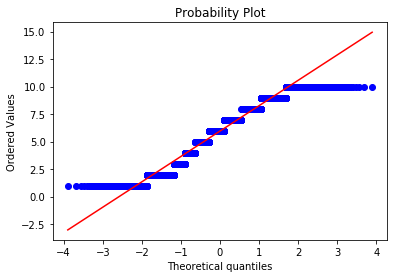

In [23]:
# Q-Q
%pylab inline
from scipy.stats import probplot
stats.probplot(num_unique_sites, dist="norm", plot=pylab)

In [24]:
# Perform the Shapiro-Wilk test for normality.
from scipy.stats import shapiro

In [25]:
stat, pvalue = shapiro(num_unique_sites)

In [26]:
stat, pvalue

(0.9546933174133301, 0.0)

In [27]:
# Test whether a sample differs from a normal distribution.
from scipy.stats import normaltest

In [28]:
normaltest(num_unique_sites)

NormaltestResult(statistic=1213.0240954590565, pvalue=3.9369913737992148e-264)

In [29]:
write_answer(2,"NO")

Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% – одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.

In [32]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [33]:
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), p = 0.95, alternative="greater")
pi_val

0.02207653769072678

In [ ]:
write_answer(3,pi_val)

Каков 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт (из п. 3)?

In [34]:
sum(has_two_similar)/ len(has_two_similar)

0.9537017281843396

In [35]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

In [36]:
print('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)))

0.95 0.957


In [ ]:
write_answer(4,'0.95 0.957')

In [ ]:
path = "10users"
sparse10_X, sparse10_y = prepare_sparse_train_set_window(path)

In [ ]:
sparse10_X.shape

In [ ]:
freq = pd.Series(np.array(sparse10_X.sum(axis = 0))[0], name = 'freq')
len(freq[freq>=1000])

First 25 sites have more than 1000 visits

In [ ]:
site_freqs =np.array(sparse10_X.sum(axis = 0))[0][:25]
site_freqs

In [ ]:
np.average(site_freqs)

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '.'

In [3]:
from collections import Counter


def get_sites(path_to_csv_files):
    """Returns :
    - dictionary of sites were used by users.
    """
    # Vars:

    # dictionary of site id's
    sites = Counter()
    # list of user files
    fns = glob(path_to_csv_files+"/*")

    # for every file
    for f in fns:
        # read user data
        ud = pd.read_csv(os.path.join(PATH_TO_DATA, f))
        # determine sites were visited
        sites.update(Counter(ud['site']))
        
    # return dictionary with sorted and enumerated sites
    result = {}
    for i, x in enumerate(sites.most_common()):
        result[x[0]] = (i+1, x[1])
    return result, fns

In [4]:
path = '10users'
sites = get_sites(path)
s = sites[0]

s = [(v[0], v[1]) for k, v in s.items()]

In [8]:
n = len(s);n

4913

In [16]:
data = np.array([x[1] for x in s])
data

array([8300, 7813, 5441, ...,    1,    1,    1])

In [17]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [18]:
avg_scores = list(map(np.average, get_bootstrap_samples(data, n)))

In [19]:
np.average(avg_scores)

28.618690556617366

In [20]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [29]:
interval = stat_intervals(avg_scores, 0.05)

In [34]:
r = lambda x : str(round(x,3))
list(map(r, interval))

['22.515', '35.763']

In [35]:
answer = " ".join(list(map(r, interval)))
answer

'22.515 35.763'

In [36]:
def write_answer(i, answer):
    with open(f"task2_{i}_answer", mode = "w") as file:
        file.write(str(answer))

In [37]:
write_answer(5, answer)